In [1]:
from pipe import *
import functools

import mPyPl as mp
from mPyPl.utils.video import *

from research.retina.detector import *
from research.optical_flow.focused import *
from research.optical_flow.dense import *
from research.optical_flow.utils import *

import cv2
import numpy as np
import pickle
import os
import sys

from keras.regularizers import l2
from keras.layers import Input, Dense, AveragePooling2D, Conv2D, Conv3D, MaxPooling2D, Dropout, Flatten, concatenate
from keras.models import Model, Sequential

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Configuration variables

data_dir = 'videos'
classes = { 'collisions' : 1, 'not-collisions': 0 }

In [4]:
## Setup RetinaFlow

retinaflow_shape = (190, 100, 2)

hist_params = [
    dict(
        bins=retinaflow_shape[1],
        lower=5,
        upper=240,
        maxv=1
    ),
    dict(
        bins=retinaflow_shape[1],
        lower=0,
        upper=6.29,
        maxv=1 
    ),
]

stream = (
    mp.get_datastream(data_dir, 'mp4', classes, split_filename='split2.txt')
    | mp.apply('filename', 'raw_rflows', load_optical)
    | mp.apply('raw_rflows', 'gradients', calc_gradients)
    | mp.apply('gradients', 'polar', to_polar)
    | mp.apply('polar', 'histograms', lambda x: video_to_hist(x, hist_params))
    | mp.apply('histograms', 'res_rflows', lambda x: zero_pad(x, retinaflow_shape))
    | mp.filter_split(mp.SplitType.Train) 
    | select(lambda x: x['res_rflows']) 
    | as_list
)

maxes = np.max(stream, axis=(0,1,2))
hist_params[0]['maxv'] = maxes[0]
hist_params[1]['maxv'] = maxes[1]
del stream

In [5]:
## Setup DenseFlow

from research.optical_flow.dense import normalize_histograms

stream = (
    mp.get_datastream(data_dir,'mp4',classes,split_filename='split2.txt')
    | mp.apply('filename','res_dflows', lambda x: np.load(x+'.flows.npy')) 
    | as_list
)

# Compute max no of frames per video
max_frames = stream | select (lambda x : x['res_dflows'].shape[0]) | max

# Compute the mix/max values of angle and magnitude of optical flow vectors
maxs = stream | select(lambda x : x['res_dflows'].max(axis=(0,1))) | mp.as_npy
mins,maxs,avgs = maxs.min(axis=0),maxs.max(axis=0),np.average(maxs,axis=0)

max_frames = 190
ang_diap = (mins[0],avgs[0])
mag_diap = (mins[1],maxs[1])
del stream

In [6]:
## Setup combined dataflow

trainstream, valstream = (
    mp.get_datastream(data_dir, 'mp4', classes, split_filename='split2.txt')
    # RetinaFlow pipeline
    | mp.apply('filename', 'raw_rflows', load_optical)
    | mp.apply('raw_rflows', 'gradients', calc_gradients)
    | mp.apply('gradients', 'polar', to_polar)
    | mp.apply('polar', 'histograms', functools.partial(video_to_hist,params=hist_params))
    | mp.apply('histograms', 'res_rflows', functools.partial(zero_pad_hist,shape=retinaflow_shape))
    | mp.delfield(['raw_rflows', 'gradients', 'polar', 'histograms'])
    # VGG16 embeddings pipeline
    | mp.apply('filename', 'raw_vgg', lambda x: np.load(x+'.vgg16.npy'))
    | mp.apply('raw_vgg','prep_vgg', functools.partial(mp.zero_pad,max_frames=125))
    | mp.apply('prep_vgg', 'res_vgg', lambda x: x.reshape(125,-1,1))
    | mp.delfield(['raw_vgg', 'prep_vgg'])
    # DenseFlow pipeline
    | mp.apply('filename','raw_dflows', lambda x: np.load(x+'.flows.npy')) 
    | mp.apply('raw_dflows','prep_dflows',functools.partial(mp.zero_pad,max_frames=max_frames)) 
    | mp.apply('prep_dflows', 'res_dflows', functools.partial(normalize_histograms, ang_diap=ang_diap, mag_diap=mag_diap)) 
    | mp.delfield(['raw_dflows', 'prep_dflows'])
    # Split
    | mp.make_train_test_split 
)

In [7]:
## RetinaFlow model

model1 = Sequential()
model1.add(AveragePooling2D((2, 2), input_shape=retinaflow_shape))
model1.add(Conv2D(64, (5,2), activation='relu', kernel_initializer='glorot_uniform'))
model1.add(Conv2D(32, (2,4), activation='relu', kernel_initializer='glorot_uniform'))
model1.add(MaxPooling2D(pool_size=(3, 3)))
model1.add(Dropout(0.3))

model1.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_uniform'))
model1.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_uniform'))
model1.add(Dropout(0.2))
model1.add(Flatten())

model1.add(Dense(100, activation='relu', kernel_initializer='glorot_uniform'))
model1.add(Dense(10, activation='relu', kernel_initializer='glorot_uniform'))
model1.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))

In [8]:
## VGG16-based model

model2 = Sequential()
model2.add(AveragePooling2D((4, 4),input_shape=(125, 7680, 1)))
model2.add(Conv2D(8, (3, 3), data_format='channels_last',activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model2.add(AveragePooling2D((4, 4)))
model2.add(Conv2D(16, (3, 3) ,activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model2.add(AveragePooling2D((4, 4)))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(100,activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))

In [9]:
## DenseFlow model

model3 = Sequential()
model3.add(AveragePooling2D((2, 2),input_shape=(max_frames, 100, 2)))
model3.add(Conv2D(8, (3, 3), data_format='channels_last',activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model3.add(AveragePooling2D((2, 2)))
model3.add(Conv2D(16, (3, 3) ,activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model3.add(AveragePooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(100,activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))

In [10]:
## Combined model
input1 = Input(shape=retinaflow_shape)
input2 = Input(shape=(125,7680,1))
input3 = Input(shape=(max_frames,100,2))
concat = concatenate([model1(input1),model2(input2), model3(input3)])
output = Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01))(concat)
                                                                                                        
model = Model(input=[input1,input2,input3],output=output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 190, 100, 2)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 125, 7680, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 190, 100, 2)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            952577      input_1[0][0]                    
__________________________________________________________________________________________________
sequential

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  


In [11]:
from keras import optimizers
from keras import callbacks
import math


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint =  callbacks.ModelCheckpoint(filepath, 
                          monitor='val_loss', 
                          verbose=0, 
                          save_best_only=True, 
                          save_weights_only=False, 
                          mode='auto', 
                          period=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.0001,
                              patience=6,
                              verbose=0, mode='auto')

history = model.fit_generator(
      trainstream | mp.infshuffle | mp.as_batch(['res_rflows', 'res_vgg', 'res_dflows'], 'class_id', batchsize=2),
      steps_per_epoch=100, 
      validation_data=valstream | mp.infshuffle() | mp.as_batch(['res_rflows', 'res_vgg', 'res_dflows'], 'class_id', batchsize=2), 
      validation_steps = 80,
      epochs=30,
      callbacks = [checkpoint, early_stopping])

Epoch 1/30
100/100 [==============================] - 10s 95ms/step - loss: 2.4076 - acc: 0.6250 - val_loss: 1.5765 - val_acc: 0.5813
Epoch 2/30
100/100 [==============================] - 4s 35ms/step - loss: 1.3579 - acc: 0.7300 - val_loss: 1.1108 - val_acc: 0.7875
Epoch 3/30
100/100 [==============================] - 4s 35ms/step - loss: 1.0646 - acc: 0.7200 - val_loss: 0.9367 - val_acc: 0.7812
Epoch 4/30
100/100 [==============================] - 4s 35ms/step - loss: 0.8960 - acc: 0.7900 - val_loss: 0.9200 - val_acc: 0.7562
Epoch 5/30
100/100 [==============================] - 4s 35ms/step - loss: 0.8686 - acc: 0.7650 - val_loss: 0.8496 - val_acc: 0.6750
Epoch 6/30
100/100 [==============================] - 4s 35ms/step - loss: 0.7904 - acc: 0.8050 - val_loss: 0.6508 - val_acc: 0.8375
Epoch 7/30
100/100 [==============================] - 4s 35ms/step - loss: 0.7178 - acc: 0.7750 - val_loss: 0.6569 - val_acc: 0.8438
Epoch 8/30
100/100 [==============================] - 4s 35ms/step -

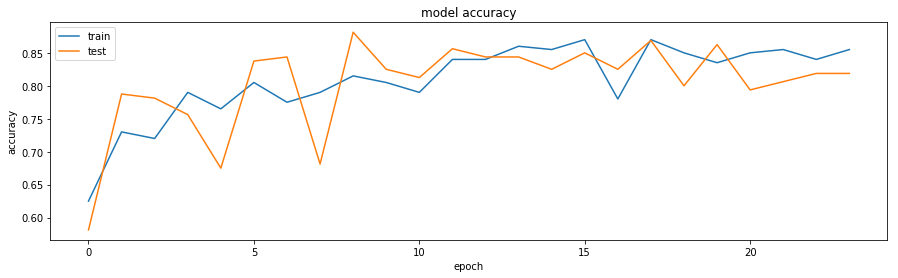

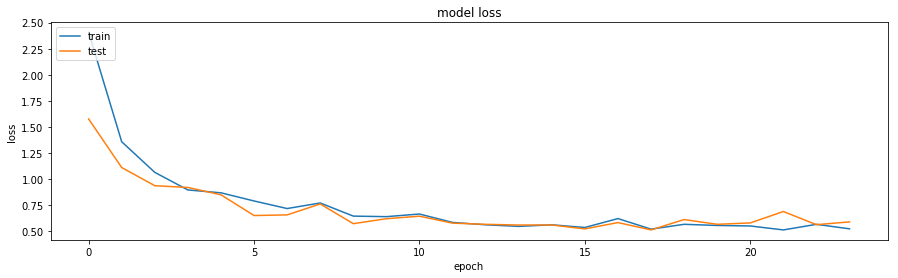

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.figure(figsize=(15,4))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()